In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

In [2]:
from src.d00_utils.utils import add_percent_columns
from src.d02_intermediate.classifier_data_api import ClassifierDataApi
from src.d01_data.block_data_api import BlockDataApi
from src.d04_modeling import propositional_classifier as pc

We load the data with an arbitrary classifier, and get an instance of the ClassifierDataApi class to access the data:

In [3]:
load_data = pc.andClassifier(["nFRL"])
cda = ClassifierDataApi()

Loading Block FRL data...0.4461
Loading Block Demographic data...0.7552
Loading Student Demographic data...2.5963


# Focal Neighborhood Proxies

So far we have developed classifiers to label each block as either focal or non-focal. Ignoring block groups due to anonimization issues, we always considered only the single-block features for this classification task. In this notebook I introduce the idea of adding a condition that in order to be focal a block must be in a "focal neighborhood." Benefits of doing this are:

1. Some blocks might contain focal students as noted in the dataset, but those students may be receiving much better infrastructure (transportation, access to good pre-K schools) than other focal students.
2. The tiebreaker will be more robust and interpretable if the focal blocks are not as scattered. The neighborhood criterion could aid reducing scattering.

Namely, we started this approach due to concerns with the focal status of FRL-receiving students in the Northwest of San Francisco. We would like to attribute some weight to the fact that those students live in a higher-developed neighborhood than students living in the Southeast of the city. We can see in the map below that many blocks in the Northwest have a high rate of FRL-receiving students.

Loading Block FRL data...0.0724
Loading Block Demographic data...0.1185
Loading Student Demographic data...0.8836


Text(0.5, 1, 'Focal (%)')

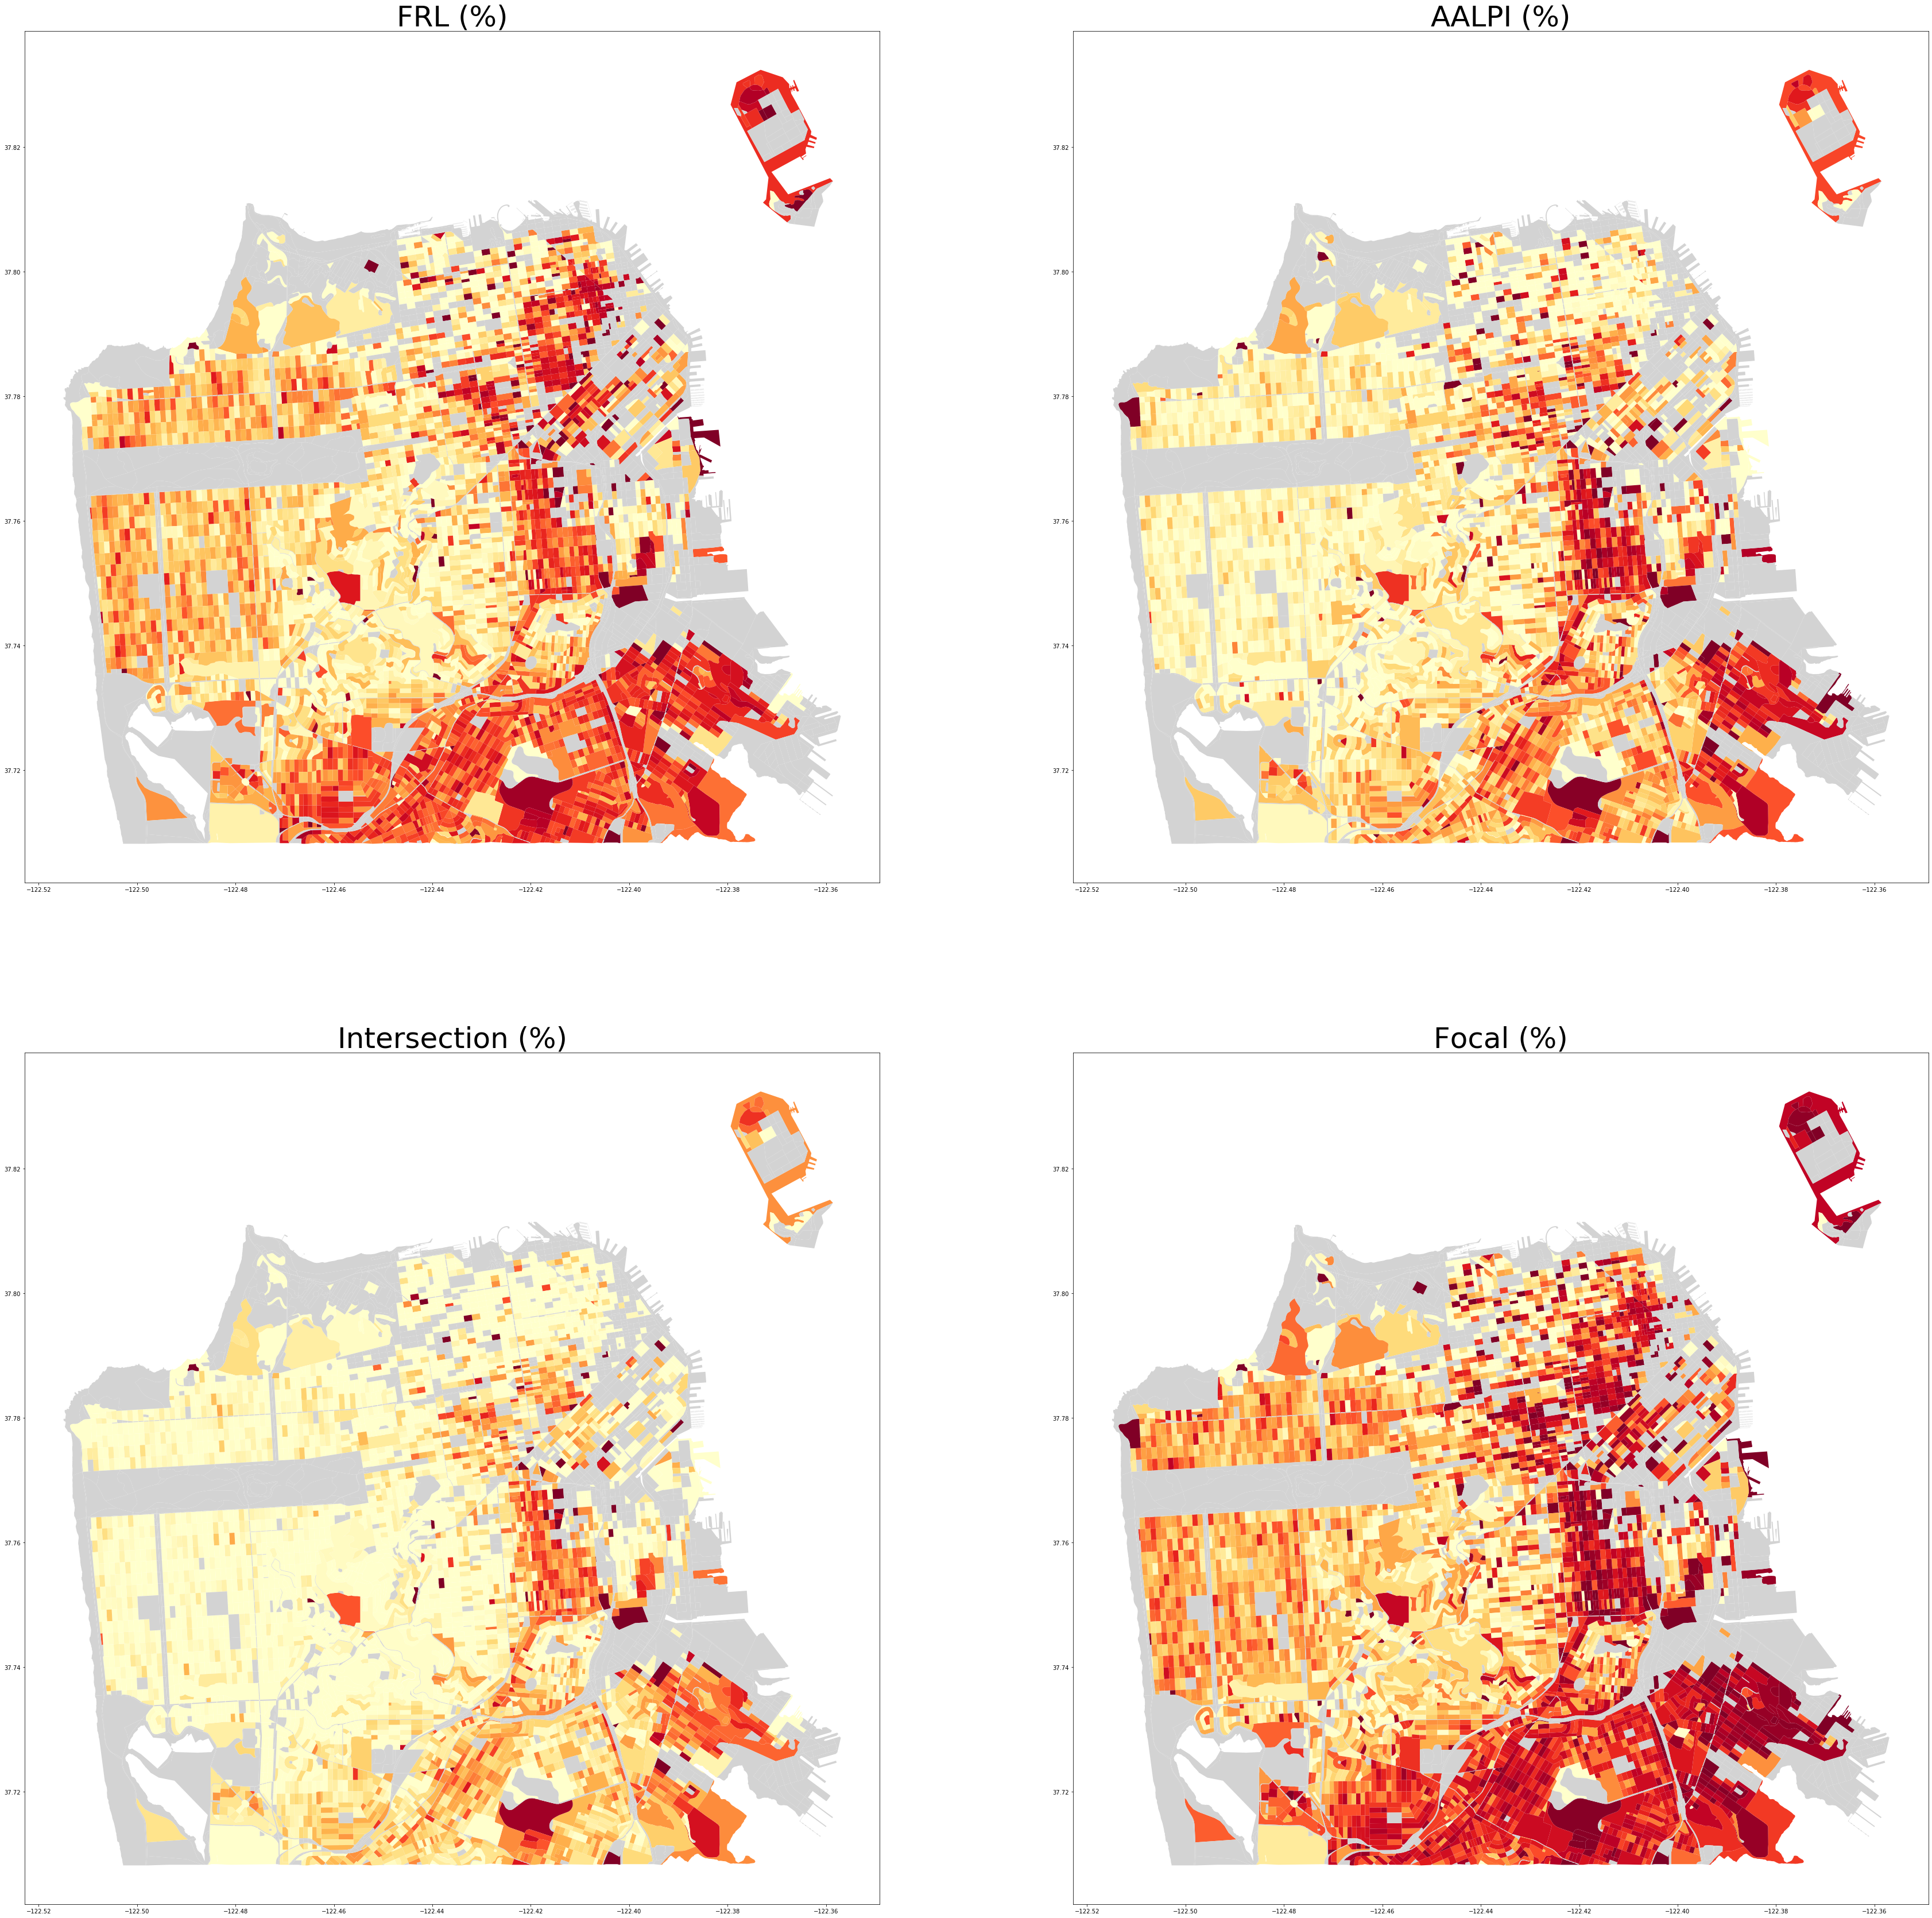

In [4]:
map_df_raw = cda.get_map_df_data(cols=["n", "nFocal", "nFRL", "nAALPI", "nBoth"])
map_df_data = add_percent_columns(map_df_raw)

fig, Axes = plt.subplots(figsize=(60,60), ncols=2, nrows=2)
axFRL = map_df_data.plot(column="pctFRL", ax=Axes[0,0], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[0,0].set_title("FRL (%)", fontsize=50)
axFRL = map_df_data.plot(column="pctAALPI", ax=Axes[0,1], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[0,1].set_title("AALPI (%)", fontsize=50)
axBoth = map_df_data.plot(column="pctBoth", ax=Axes[1,0], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[1,0].set_title("Intersection (%)", fontsize=50)
axFocal = map_df_data.plot(column="pctFocal", ax=Axes[1,1], cmap="YlOrRd",
                         legend=False, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
Axes[1,1].set_title("Focal (%)", fontsize=50)

The main idea is to incorporate the neighborhood condition (N_COND) into the propositional classifier. This way N_COND will either evaluate to True or False for each block. Blocks in the same neighborhood will have the same value of N_COND. Probably it will be better to incorporate (to adhere to goals 1 and 2) this condition in conjunction to an existing tiebreaker (PROP). That is, a block receives a tiebreaker if the following expression is true:

$$ \text{PROP} \quad\text{and}\quad \text{N_COND}$$

Meaning that the block must satisfy simultaneously the (1) block-level criteria and (2) the neighborhood condition. An example of this classifier would be, assuming we could measure a neighborhood median income directly, to give a tiebreaker to blocks satisfying:

$$ (\text{pctAALPI }\geq 0.5\quad\text{or}\quad \text{pctFRL } \geq 0.6)\quad\text{and}\quad \text{NbhdMedianInc} \leq 50,000 $$

The definition of neighborhood we will probably use is the BlockGroup. BlockGroups can be visualized in the following map. Note that trimming the Block Group id (10 digits by default) leads to a coarser neighborhood partition:

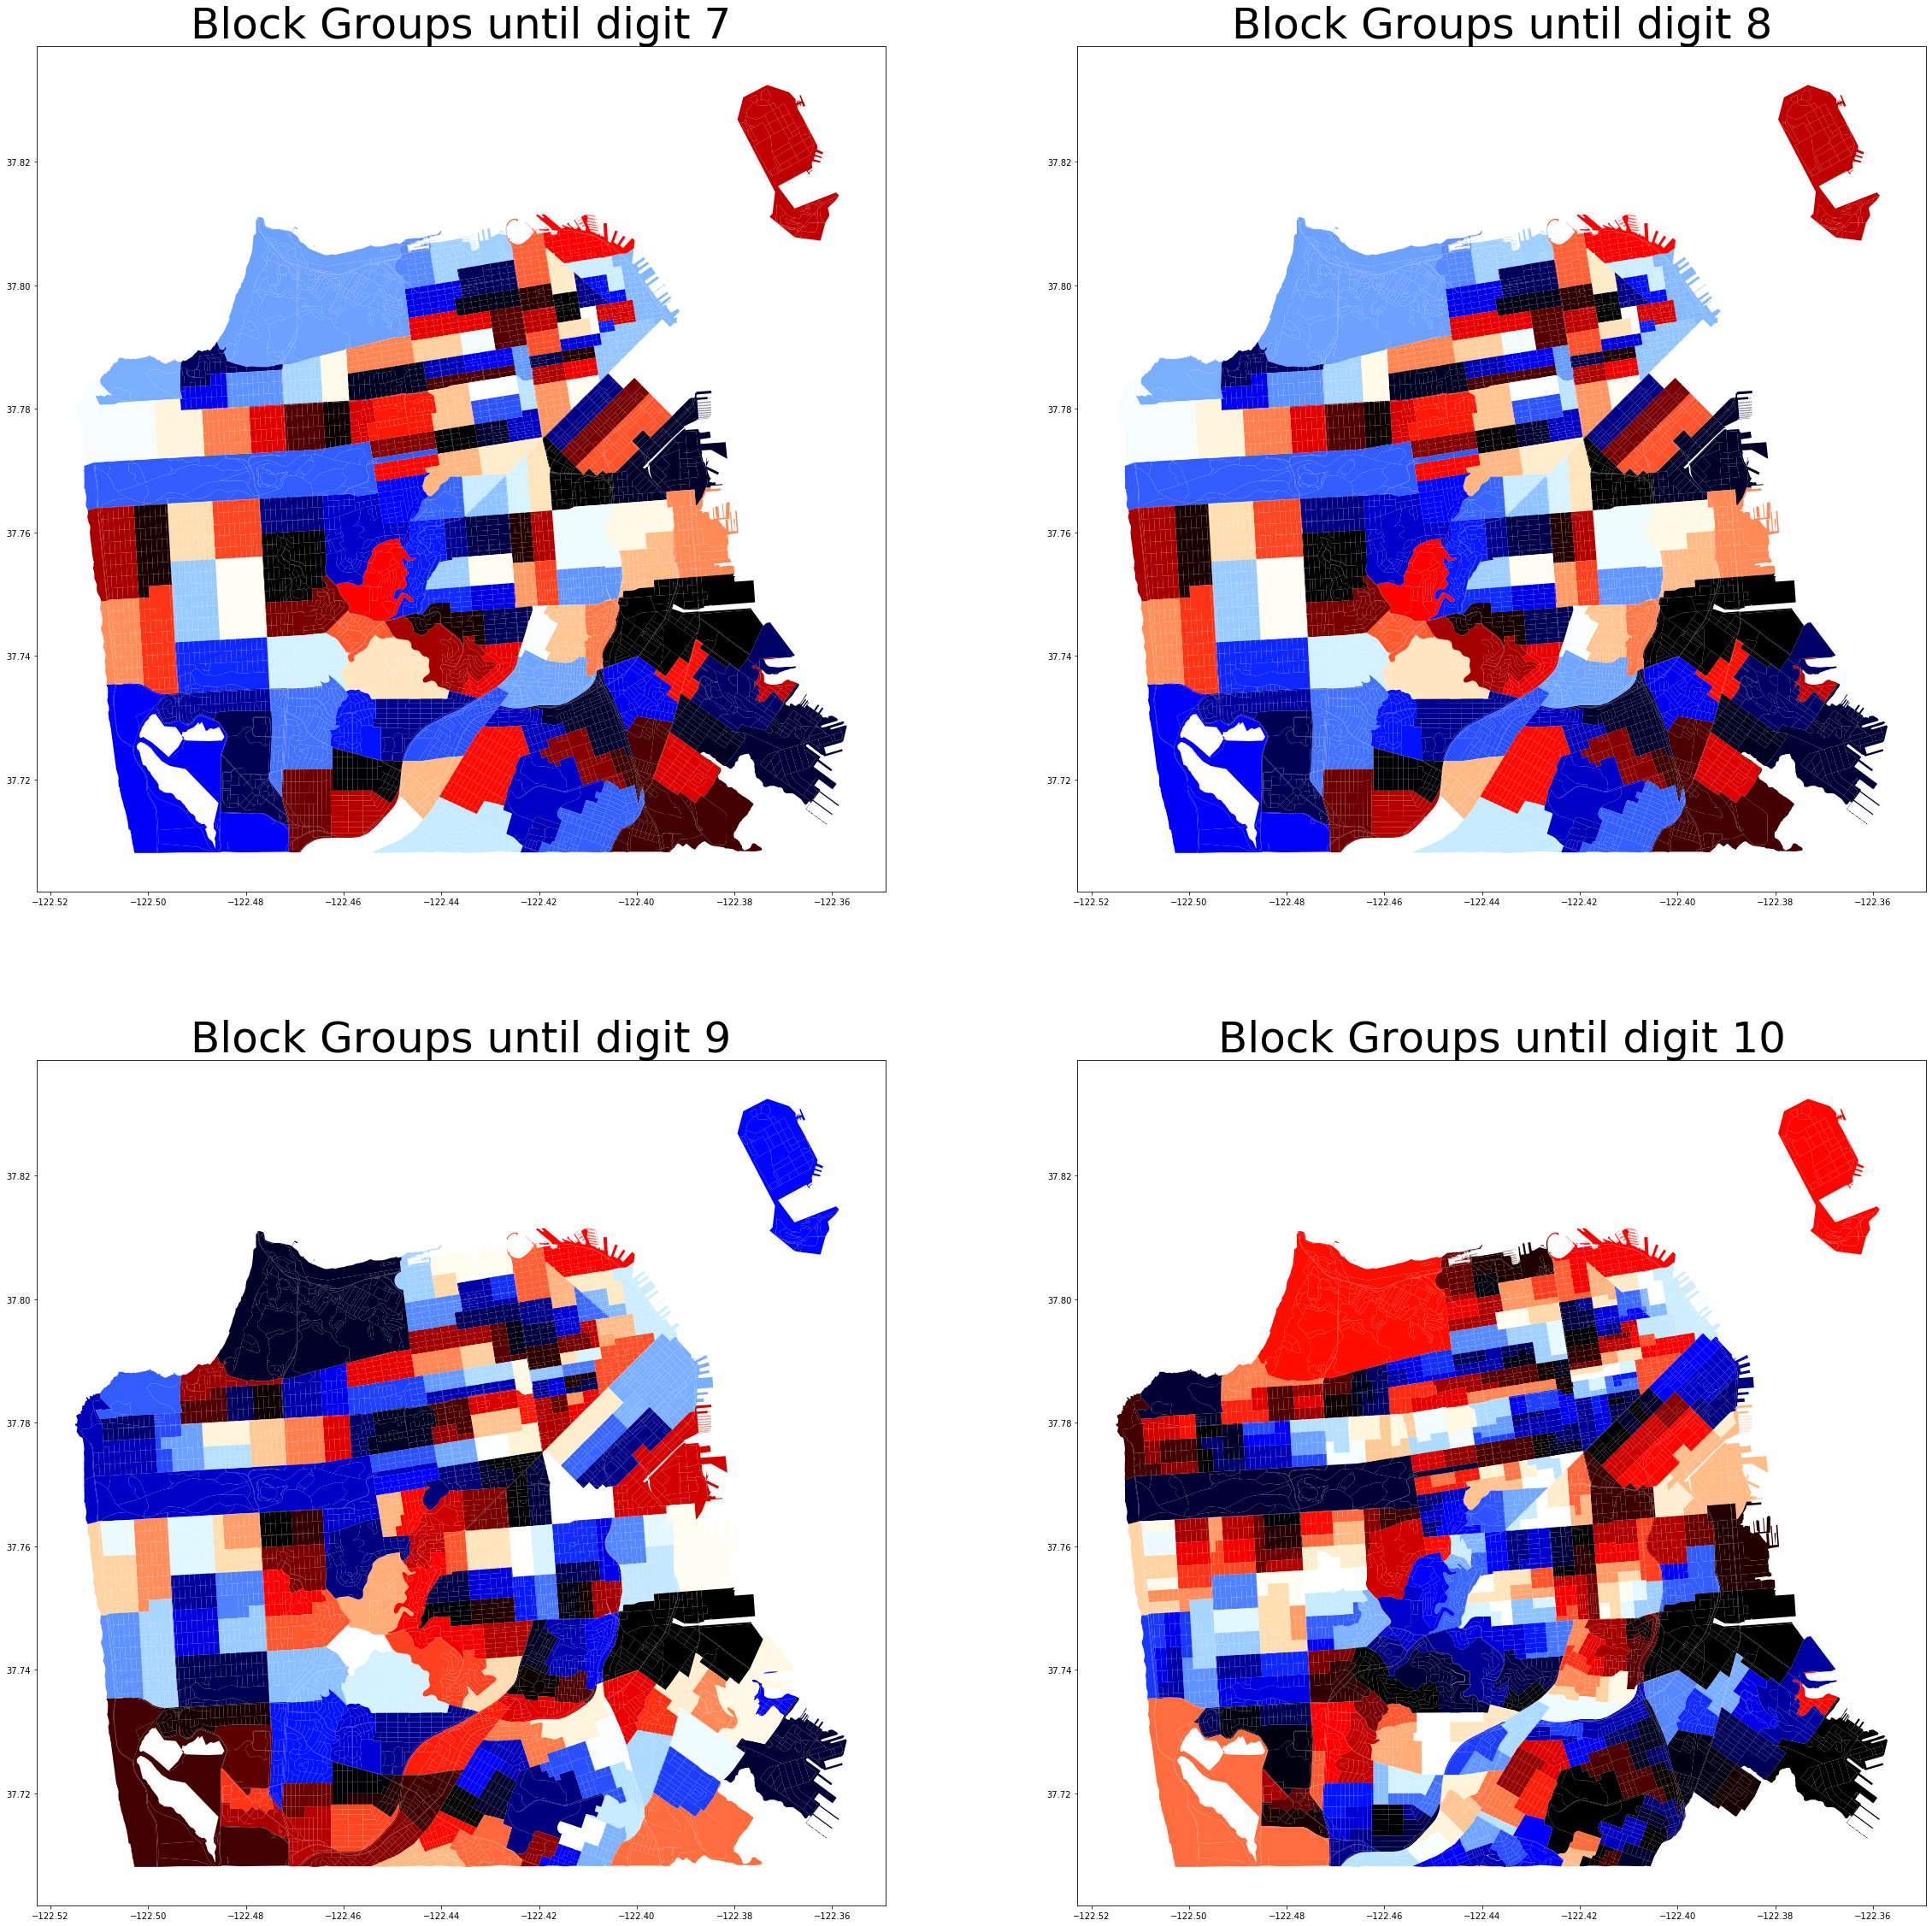

In [5]:
map_df_bg = cda.get_map_df_data(cols=["BlockGroup"])
fig, Axes = plt.subplots(figsize=(40,40), nrows=2, ncols=2)

k=8
for ax in Axes.flatten():
    new_map_df = map_df_bg.copy()
    new_map_df["BlockGroup"] = new_map_df["BlockGroup"].astype(str).str.slice(stop=k)
    new_map_df["RankGroup"] = new_map_df["BlockGroup"].rank(method="dense")
    ax = new_map_df.plot(column="RankGroup", ax=ax, cmap="flag",
                        legend=False, missing_kwds={'color': 'lightgrey'})
    ax.set_title("Block Groups until digit " + str(k-1), fontsize=50)
    k += 1

Another option of neighborhood unit is the analysis neighborhood.

Text(0.5, 1, 'San Francisco Analysis Neighborhoods')

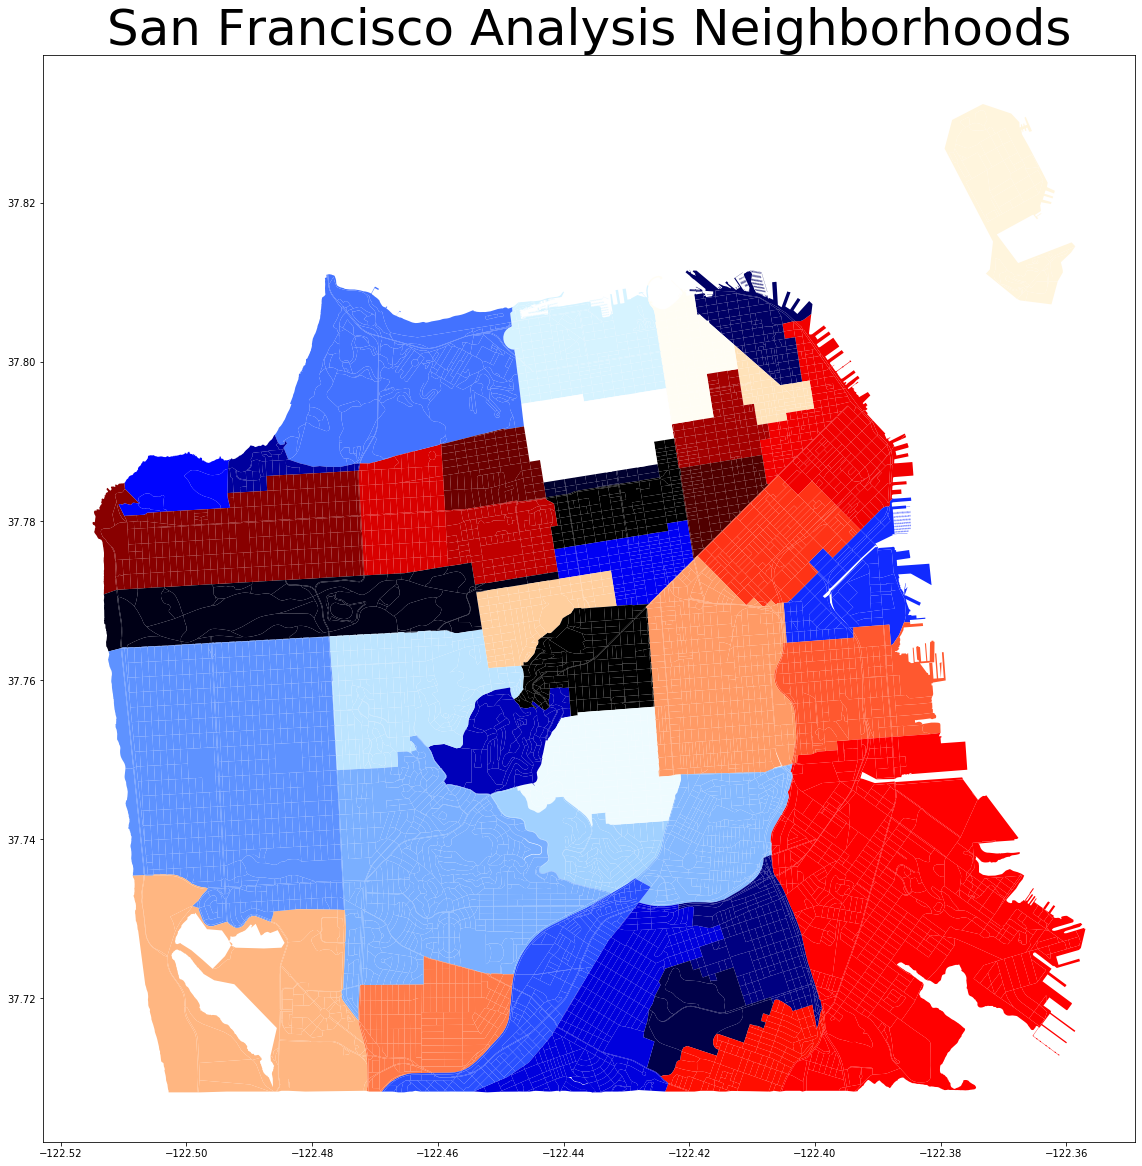

In [6]:
map_df_nb = cda.get_map_df_data(cols=["Neighborhood"])
fig, ax = plt.subplots(figsize=(20,20))
ax = map_df_nb.plot(column="Neighborhood", ax=ax, cmap="flag",
                    legend=False, missing_kwds={'color': 'lightgrey'},
                    categorical=True)
ax.set_title("San Francisco Analysis Neighborhoods", fontsize=50)

We can initialize a classifier with a group_criterion to be either None (default), "block_group", or "nbhd" and be in one of those scenarios. If we select "block_group", we can specify the coarseness of the block group id (default is 8 digits):

In [7]:
c1 = pc.andClassifier(["pctFocal"], group_criterion="block_group", len_BG=8)
c2 = pc.andClassifier(["pctFocal"], group_criterion="nbhd")
c3 = pc.andClassifier(["pctFocal"], group_criterion=None)  #default!

## 1. FRL and AALPI based Proxies:

The first time around, I will build proxies only taking into account the focal student data provided by the district. This will enforce that a tiebreaker-receiving block is not completely detached from its neighborhood judging by the same criteria.

In [ ]:
c1 = pc.andClassifier(["pctFocal"],len_BG=7)
c2 = pc.andClassifier(["BG_pctFocal"], len_BG=7)

For example, if we were to give the tiebreaker only to blockgroups where the percentage of focal students is above a certain threshold, we would obtain the following ROC curve (and compare it to the curve obtained from only considering the individual percentage):

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
param_arr = [x/10 for x in range(11)]

for col in ["pctFocal", "BG_pctFocal"]:
    classifier = pc.andClassifier([col])
    df = classifier.get_roc(param_arr)
    data_fpr = df["fpr"].values
    data_tpr = df["tpr"].values
    ax.plot(data_fpr, data_tpr, linestyle='solid', label=col)

ax.legend(loc="lower right")
plt.legend(fontsize=25)

ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title("ROC curve for naive classification based on a single feature", fontsize=30)

plt.show()

For a few values of the threshold we can view the differences in the solution:

In [ ]:
fig, Axes = plt.subplots(figsize=(40,60), nrows=3, ncols=2)

for alpha, i in zip([0.25, 0.5, 0.75], [0, 1, 2]):
    j=0
    for classifier in [c1, c2]:
        map_df = classifier.get_tiebreakermap(alpha)
        Axes[i, j] = map_df.plot(column="tiebreaker", ax=Axes[i,j], cmap="viridis",
                                 legend=False, missing_kwds={'color': 'lightgrey'})
        plt.axis('off')
        j += 1

cols = ["Block Level Focal (%)", "Group Level Focal (%)"]
rows = ["> 25%", "> 50%", "> 75%"]
for ax, col in zip(Axes[0], cols):
    ax.set_title(col, fontsize=80)
for ax, row in zip(Axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=60)
fig.tight_layout()
plt.show()

In [ ]:
c1.data

## 2. Neighborhood Socioeconomic Score (Henry's index) based Proxies: